In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

In [74]:
# default = [0,0,0,0,0]

# images = []
# annotations = []
# for path in tqdm(os.listdir('../input/face-mask-detection/annotations')):
    
    
#     tree = ET.parse(os.path.join('../input/face-mask-detection/annotations',path))
#     root = tree.getroot()
    
#     imgpath = os.path.join('../input/face-mask-detection/images',path[:-4]+'.png')
#     image = cv2.imread(imgpath)
#     height,width = image.shape[:2]
    
    
    
#     flag = False
#     labels = []
#     notations = []
    
#     for i,neighbor in enumerate(root.iter('bndbox')):
#         xmin = int(neighbor.find('xmin').text)/width 
#         ymin = int(neighbor.find('ymin').text)/height 
#         xmax = int(neighbor.find('xmax').text)/width 
#         ymax = int(neighbor.find('ymax').text)/height 
#         notations.append([xmin,ymin,xmax,ymax,1])
#         if i==5:
#             flag = True
#             break
#     for i in range(i,4):
#         notations.append(default)
    
    
#     if not flag:
#         annotations.append(notations)
#         image = cv2.resize(image,(224,224))
#         images.append(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    


  0%|          | 0/853 [00:00<?, ?it/s]

In [25]:
default = [0,0,0,0,0]

images = []
annotations = []
for path in tqdm(os.listdir('../input/face-mask-detection/annotations')):
    
    
    tree = ET.parse(os.path.join('../input/face-mask-detection/annotations',path))
    root = tree.getroot()
    
    imgpath = os.path.join('../input/face-mask-detection/images',path[:-4]+'.png')
    image = cv2.imread(imgpath)
    height,width = image.shape[:2]
    
    image = cv2.resize(image,(224,224))
    images.append(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    

    labels = []
    notations = []
    for neighbor in root.iter('object'):
        labels.append(neighbor.find('name').text)
    for i,neighbor in enumerate(root.iter('bndbox')):
        xmin = int((neighbor.find('xmin').text))/width 
        ymin = int(neighbor.find('ymin').text)/height 
        xmax = int(neighbor.find('xmax').text)/width 
        ymax = int(neighbor.find('ymax').text)/height
        notations.append([xmin,ymin,xmax,ymax,1])
        if i==9:
            break
    for i in range(i,9):
        notations.append(default)

    annotations.append(notations)

  0%|          | 0/853 [00:00<?, ?it/s]

In [26]:
images = np.array(images)
images = images/255

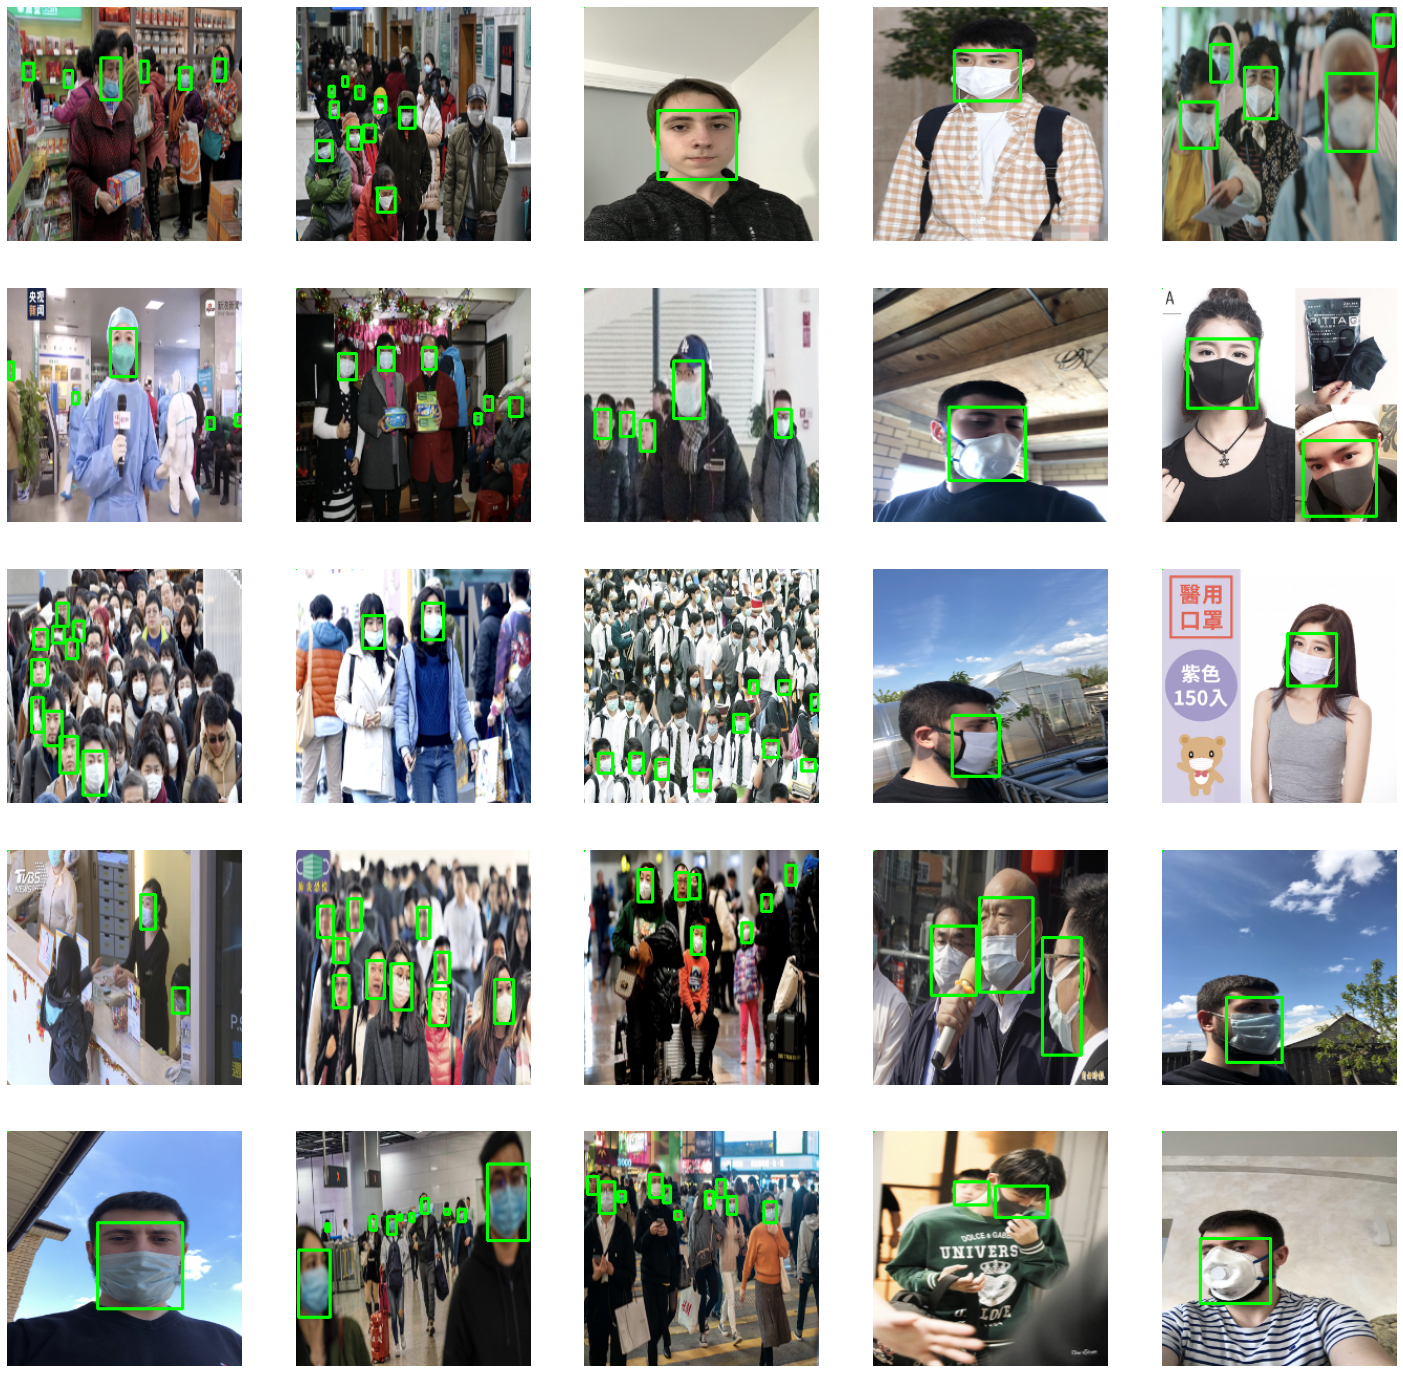

In [27]:

plt.figure(figsize=(25,25))
start = 0
end = 25
for i,img in enumerate(images[start:end].copy()):
    plt.subplot(5,5,i+1)
    for notations in annotations[start]:
        [xmin,ymin,xmax,ymax,conf] = notations
        cv2.rectangle(img,(int(xmin*224),int(ymin*224)),(int(xmax*224),int(ymax*224)),(0,255,0),2)
            
    plt.imshow(img)
    plt.axis('off')
    start += 1

In [29]:
annotations = np.array(annotations)
len(images),len(annotations)

(853, 853)

In [30]:
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Rescaling,BatchNormalization,Reshape,Input
from tensorflow.keras.losses import MeanSquaredError
from keras.models import Model

In [32]:
inputs = Input(shape=(224,224,3))
x = Conv2D(16,(3,3),activation='relu')(inputs)
x = MaxPool2D()(x)

x = Conv2D(32,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# x = Conv2D(256,(3,3),activation='relu')(x)
# x = MaxPool2D()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

x = Flatten()(x)

# x = Dense(512,activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

prediction = Dense(50,activation='sigmoid')(x)
prediction = layers.Reshape((10,5))(prediction)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer = 'adam',loss = MeanSquaredError())
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 54, 54, 32)        128       
_________________________________________________________________
dropout_23 (Dropout)         (None, 54, 54, 32)        0   

In [39]:
model.fit(images[:700],annotations[:700],epochs = 100)

Epoch 1/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0056
Epoch 2/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0056
Epoch 3/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0056
Epoch 4/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0052
Epoch 5/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0054
Epoch 6/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0058
Epoch 7/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0053
Epoch 8/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0050
Epoch 9/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0053
Epoch 10/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0052
Epoch 11/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0050
Epoch 12/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0055
Epoch 13/100
22/22 [=====

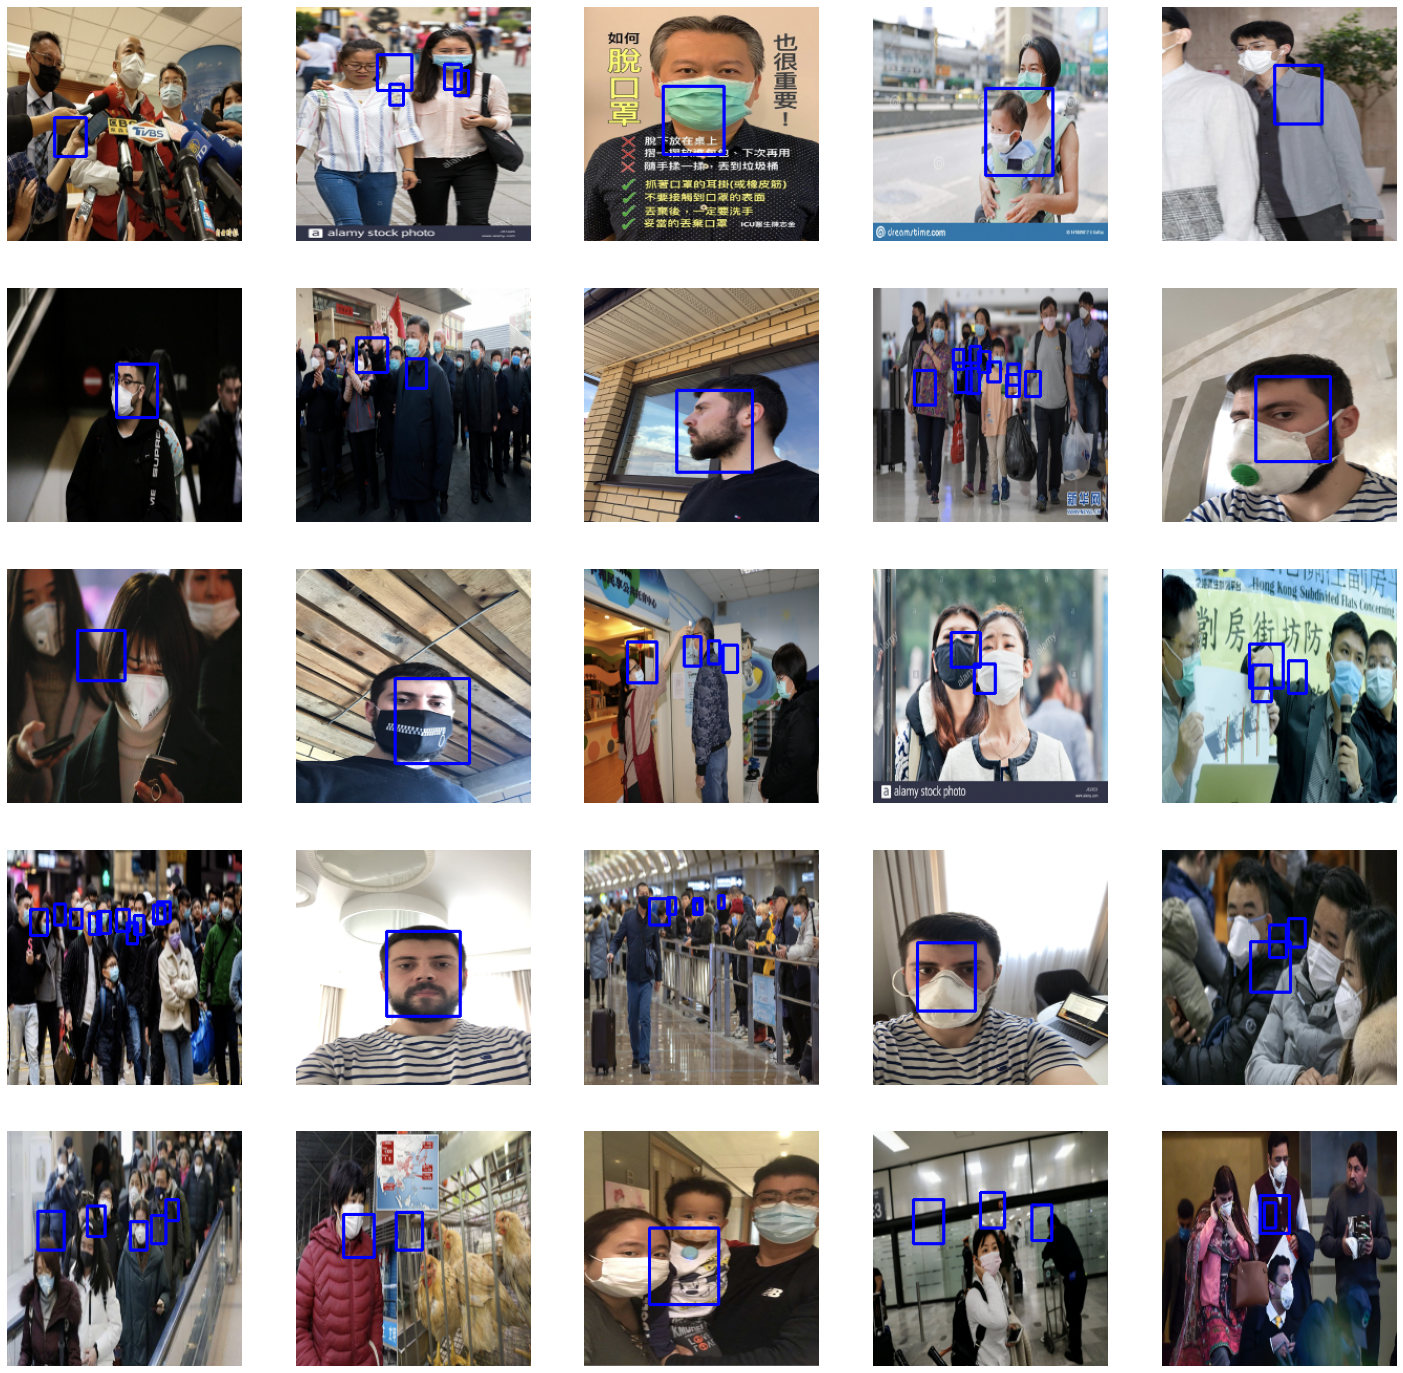

In [42]:
plt.figure(figsize=(25,25))
start= 725
end = start + 25
for i,img in enumerate(images[start:end].copy()):
    img = images[start].copy()

    predictions = model.predict(images[start].reshape(1,224,224,3))
    
    plt.subplot(5,5,i+1)
    for notations in predictions[0]:
        [xmin,ymin,xmax,ymax,conf] = notations
        if conf>0.9:
            cv2.rectangle(img,(int(xmin*224),int(ymin*224)),(int(xmax*224),int(ymax*224)),(0,0,255),2)
    plt.imshow(img)
    plt.axis('off')
    start+=1

In [41]:
model.evaluate(images[700:],annotations[700:])

5/5 [==============================] - 0s 11ms/step - loss: 0.0523


0.05231268331408501

In [21]:
model.save('./detection.h5')